### demonstrating clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import collections

from util_transaction_data import *

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)


In [3]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)

baskets = baskets[baskets.merchant_id !=191] # this is a system account
baskets = baskets[baskets.merchant_id !=11] # this is a system account
baskets = baskets[baskets.top_cat !=27] # remove cgarette top categories
baskets = baskets[baskets.sub_cat !=86] # remove cigarette sub categories

baskets.dropna(inplace=True) # some rows had NA in top_cat and sub_cat

cat_mapping_file = './top_category_mapping_new.csv'
top_cat_names = pd.read_csv(cat_mapping_file)
df = baskets.merge(top_cat_names[["top_cat_id","top_cat_en"]], left_on="top_cat",right_on="top_cat_id")
baskets = df.drop(axis=1, columns=["top_cat_id"])

In [4]:
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)
merchant_attributes = get_merchant_attributes(baskets)

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

In [26]:
merchant_attributes.head()

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month,cluster
0,1,3142000.0,10,13,21,4,6,7,26,10,17,314200.000000,9,1
1,2,5128100.0,11,12,24,4,8,9,33,12,18,466190.909091,13,1
2,3,9739000.0,28,11,16,5,10,21,97,21,41,347821.428571,6,2
3,4,1021000.0,2,19,20,2,2,2,9,5,5,510500.000000,2,4
4,5,724500.0,2,13,18,2,2,2,10,5,8,362250.000000,6,2


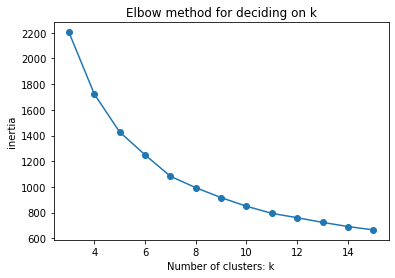

In [27]:
df = merchant_attributes
colnames = merchant_attributes.columns[1:] # do not use merchant_id in clustering
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

#kmeans.cluster_centers_

In [31]:
df = merchant_attributes
colnames = merchant_attributes.columns[1:]
k = 7
merchant_attributes_kmeans = run_kmeans(df, colnames,k,)
merchant_attributes_kmeans.groupby("cluster").size()


cluster
0     57
1     50
2     50
3     18
4     66
5      6
6    102
dtype: int64

In [33]:
merchant_attributes_kmeans[merchant_attributes_kmeans["cluster"]==5]

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month,cluster
11,15,5.486350e+08,287,6,24,17,51,279,382,29,71,1.911620e+06,19,5
12,16,6.310355e+08,218,6,24,17,48,197,426,28,68,2.894658e+06,19,5
16,20,5.455805e+08,216,6,24,18,44,200,361,28,60,2.525836e+06,19,5
48,52,1.058679e+09,383,9,24,16,53,346,523,31,76,2.764175e+06,16,5
124,128,6.868406e+08,279,10,24,15,47,262,503,29,80,2.461794e+06,15,5
201,207,7.960370e+08,256,10,24,15,51,244,223,23,48,3.109520e+06,15,5


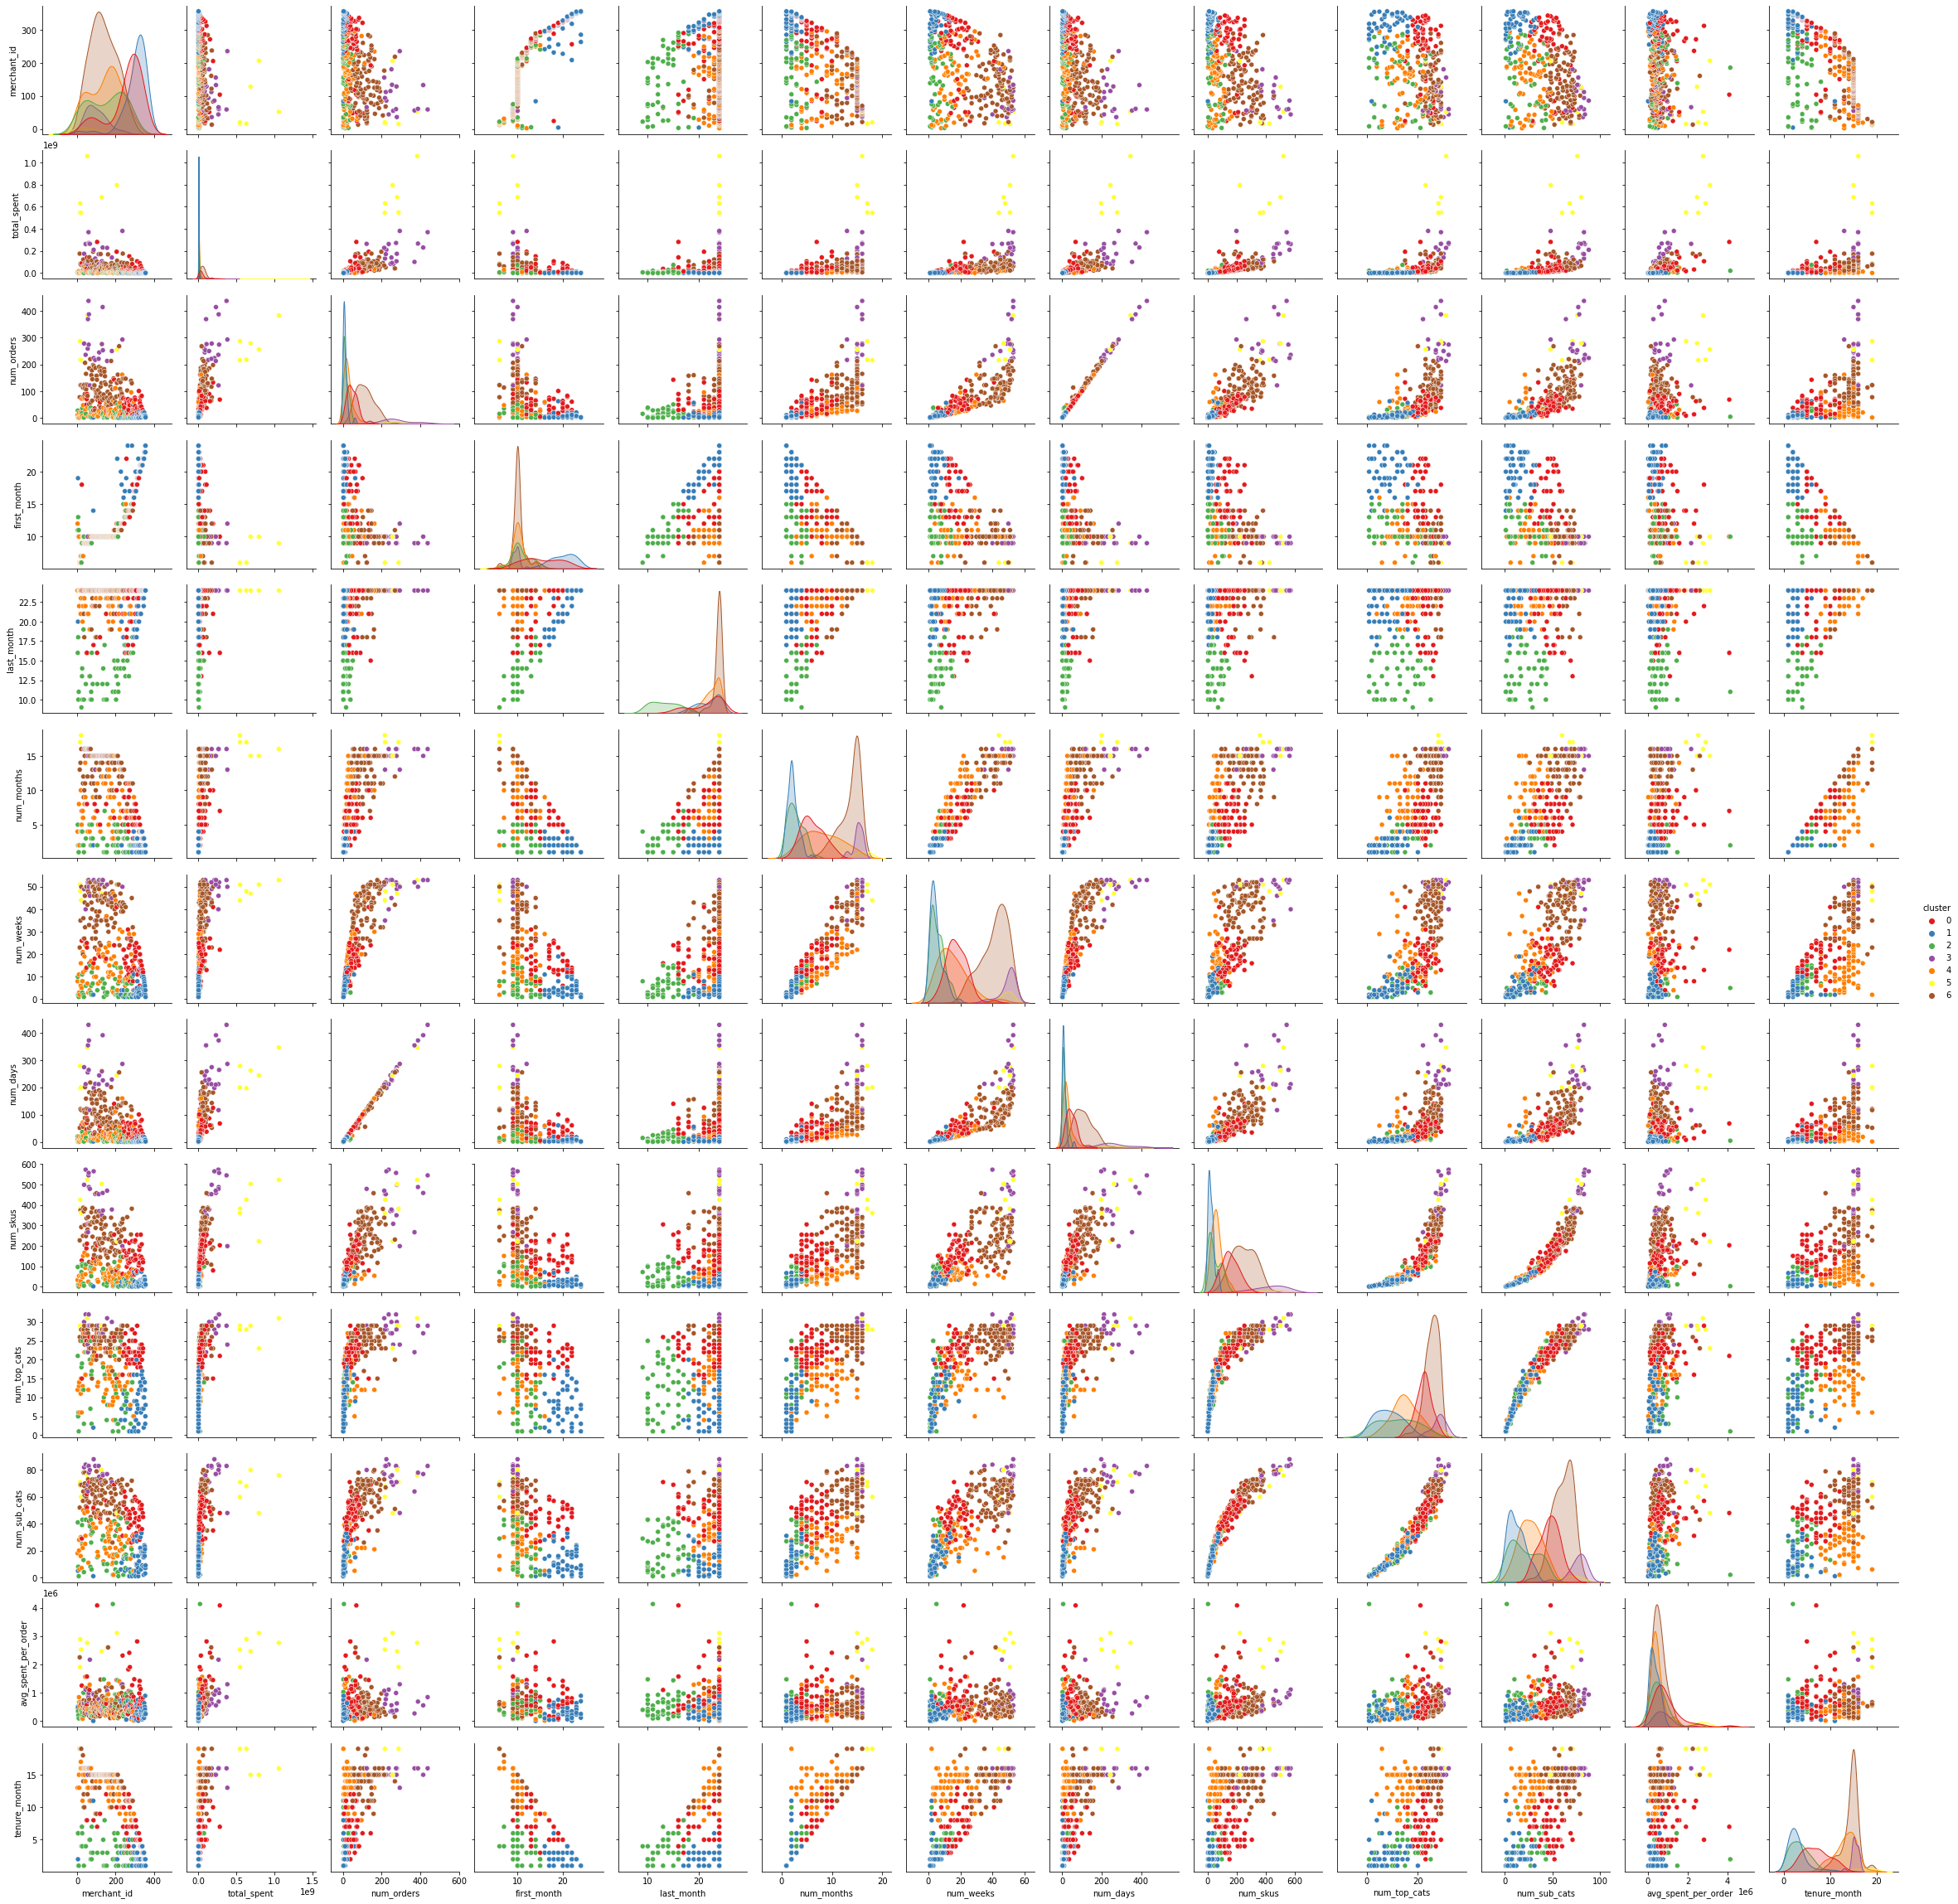

In [35]:
sns.pairplot(data=merchant_attributes_kmeans[1:], hue="cluster", palette="Set1")


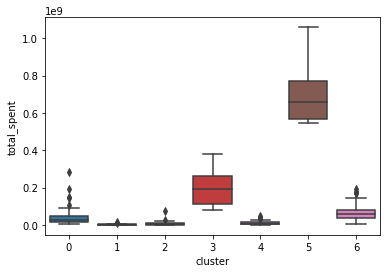

In [47]:
ax = sns.boxplot(x="cluster", y="total_spent", data=merchant_attributes_kmeans)

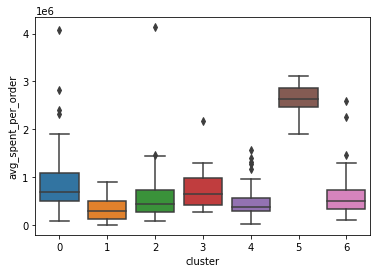

In [44]:
ax = sns.boxplot(x="cluster", y="avg_spent_per_order", data=merchant_attributes_kmeans)

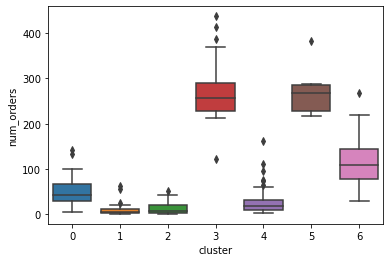

In [45]:
ax = sns.boxplot(x="cluster", y="num_orders", data=merchant_attributes_kmeans)

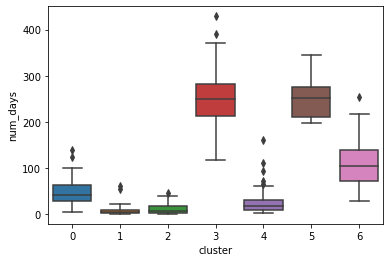

In [46]:
ax = sns.boxplot(x="cluster", y="num_days", data=merchant_attributes_kmeans)

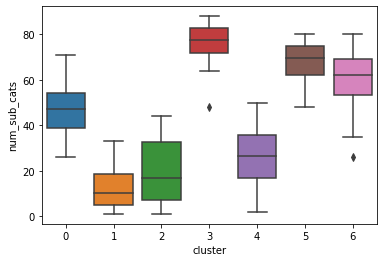

In [49]:
ax = sns.boxplot(x="cluster", y="num_sub_cats", data=merchant_attributes_kmeans)

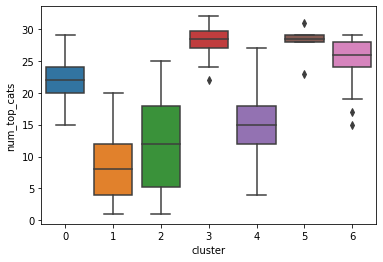

In [48]:
ax = sns.boxplot(x="cluster", y="num_top_cats", data=merchant_attributes_kmeans)

In [50]:
merchant_attributes_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   merchant_id          349 non-null    int64  
 1   total_spent          349 non-null    float64
 2   num_orders           349 non-null    int64  
 3   first_month          349 non-null    int64  
 4   last_month           349 non-null    int64  
 5   num_months           349 non-null    int64  
 6   num_weeks            349 non-null    int64  
 7   num_days             349 non-null    int64  
 8   num_skus             349 non-null    int64  
 9   num_top_cats         349 non-null    int64  
 10  num_sub_cats         349 non-null    int64  
 11  avg_spent_per_order  349 non-null    float64
 12  tenure_month         349 non-null    int64  
 13  cluster              349 non-null    int32  
dtypes: float64(2), int32(1), int64(11)
memory usage: 36.9 KB


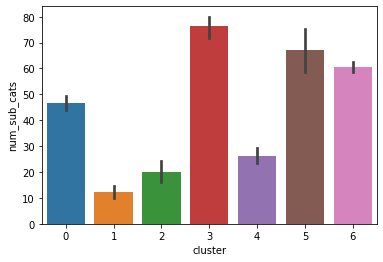

In [51]:
ax = sns.barplot(x="cluster", y="num_sub_cats", data=merchant_attributes_kmeans)

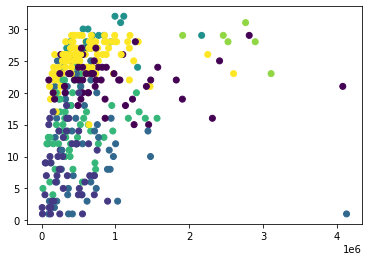

In [52]:
plt.scatter(merchant_attributes["avg_spent_per_order"], merchant_attributes["num_top_cats"],c=merchant_attributes.cluster)
plt.show()

<AxesSubplot:>

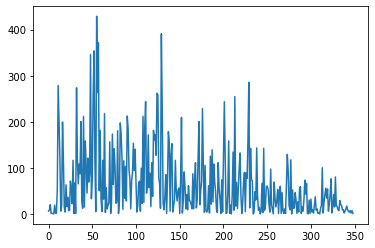

In [53]:
merchant_attributes.num_days.plot()

<AxesSubplot:>

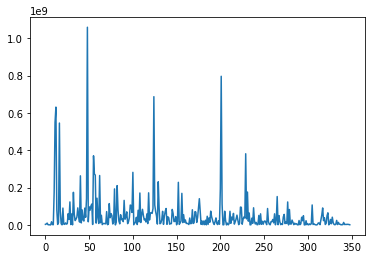

In [24]:
merchant_attributes.total_spent.plot()

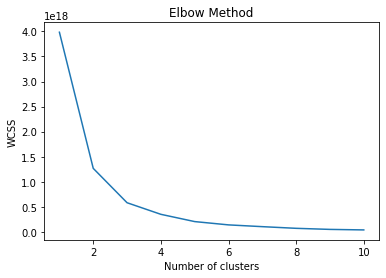

In [54]:
merchant_attributes_data = merchant_attributes[1:]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(merchant_attributes_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

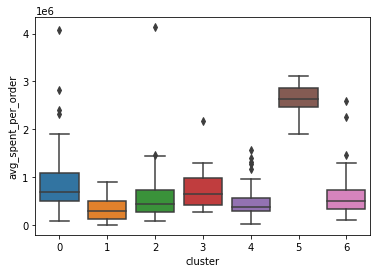

In [56]:
ax = sns.boxplot(x="cluster", y="avg_spent_per_order", data=merchant_attributes_data)

### cluster 5 looks like containing merchant_attributes who have high average spending per orders.

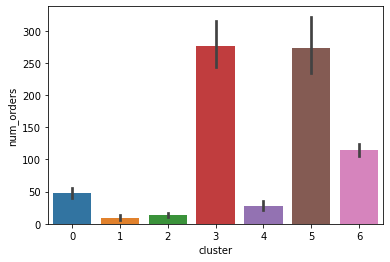

In [57]:
ax = sns.barplot(x="cluster", y="num_orders", data=merchant_attributes_data)

<Figure size 1080x720 with 0 Axes>

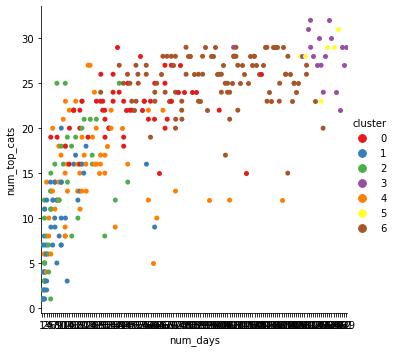

In [58]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_top_cats",data=merchant_attributes_data, hue="cluster", palette="Set1",ci="sd")

<Figure size 1080x720 with 0 Axes>

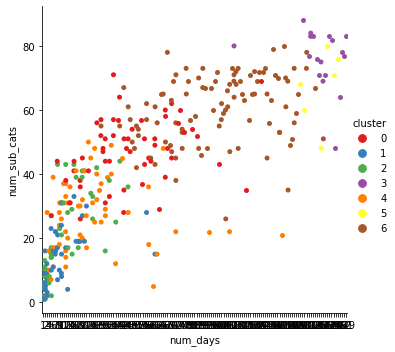

In [59]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_sub_cats",data=merchant_attributes_data, hue="cluster", palette="Set1",ci="sd")

<Figure size 1080x720 with 0 Axes>

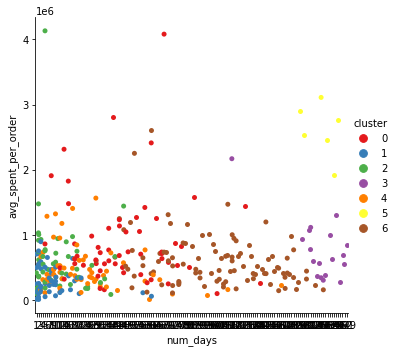

In [60]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(y="avg_spent_per_order", x = "num_days",data=merchant_attributes_data, hue="cluster", palette="Set1",ci="sd")